<a href="https://colab.research.google.com/github/nitinfaye/K-means-Clustering-algorithms/blob/main/kmean_clustering_pyspark_hacking_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 13.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=e4c14bb81e5b5dd6ade69ad92e332cc794b89678b95e75496e9b00de244cf69f
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
!pip install -q findspark

In [ ]:
import pyspark
import findspark
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("num_of_hackers").getOrCreate()

In [ ]:
spark

In [ ]:
df = spark.read.csv("hack_data.csv", header=True, inferSchema=True)

In [ ]:
df.show(2)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
only showing top 2 rows



In [ ]:
round(df.describe().toPandas(), 2)

,summary,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
0,count,334,334,334,334,334,334,334
1,mean,30.008982035928145,607.2452694610777,0.5119760479041916,5.258502994011977,10.838323353293413,None,57.342395209580864
2,stddev,14.088200614636158,286.33593163576757,0.5006065264451406,2.30190693339697,3.06352633036022,None,13.41106336843464
3,min,1.0,10.0,0,1.0,6.0,Afghanistan,40.0
4,max,60.0,1330.5,1,10.0,15.0,Zimbabwe,75.0


In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
df.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [ ]:
feat_cols = ['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed']

In [ ]:
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features')

In [ ]:
final_df = assembler.transform(df)

In [ ]:
from pyspark.ml.feature import StandardScaler

In [ ]:
scaler = StandardScaler(inputCol='features', 
                        outputCol='scaled_feat',
                        withStd = True,
                        withMean = False)

In [ ]:
scaled_model = scaler.fit(final_df)

In [ ]:
cluster_df = scaled_model.transform(final_df)

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
eval = ClusteringEvaluator(predictionCol="prediction",
                           featuresCol="scaled_feat",
                           metricName="silhouette",
                           distanceMeasure="squaredEuclidean")

In [ ]:
silhouette_score = []
print("""
Silhoutte Scores for K Mean Clustering
======================================
Model\tScore\t
=====\t=====\t
""")
for k in range(2,11):
  kmeans_algo = KMeans(featuresCol='scaled_feat',k=k)
  kmeans_fit = kmeans_algo.fit(cluster_df)
  output = kmeans_fit.transform(cluster_df)
  score = eval.evaluate(output)
  silhouette_score.append(score)
  print(f"K{k}\t{round(score,2)}\t")



Silhoutte Scores for K Mean Clustering
Model	Score	
=====	=====	

K2	0.82	
K3	0.76	
K4	0.68	
K5	0.57	
K6	0.64	
K7	0.57	
K8	0.46	
K9	0.39	
K10	0.38	


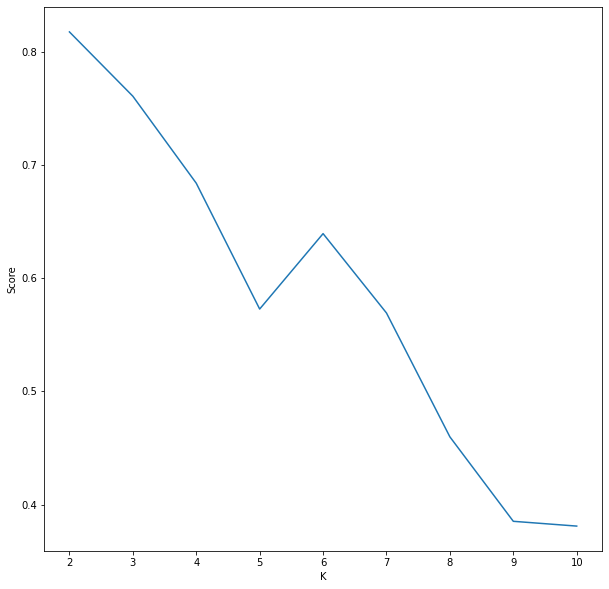

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(range(2,11), silhouette_score)
ax.set_xlabel("K")
ax.set_ylabel("Score");